In [37]:
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

mt5.initialize()
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 10, 31)
timeframe = mt5.TIMEFRAME_H4

# 1) Choose your FX assets
assets = [
    "EURUSD",
    "GBPUSD",
    "AUDUSD",
    "USDJPY",
    "USDCHF",
    "USDCAD",
    "NZDUSD",
]

# assumes: mt5.initialize() already done,
# and you already defined: timeframe, start_date, end_date

returns_list = []

for asset in assets:
    rates = mt5.copy_rates_range(asset, timeframe, start_date, end_date)
    if rates is None or len(rates) == 0:
        raise RuntimeError(f"No data returned for {asset}")

    df = pd.DataFrame(rates)

    # convert MT5 time to datetime index
    df["time_dt"] = pd.to_datetime(df["time"], unit="s")
    df = df.set_index("time_dt")

    # log returns on close prices
    log_ret = np.log(df["close"]).diff().dropna()
    log_ret.name = asset  # so it becomes the column name

    returns_list.append(log_ret)

# 2) Align on common timestamps across all assets
#    (inner join on the index)
returns_df = pd.concat(returns_list, axis=1, join="inner").dropna()

# 3) Build X: T x N matrix of returns
X = returns_df.values  # shape (T, N)

print("returns_df.shape =", returns_df.shape)
print("X.shape =", X.shape)
print("columns (assets) =", returns_df.columns.tolist())


returns_df.shape = (4410, 7)
X.shape = (4410, 7)
columns (assets) = ['EURUSD', 'GBPUSD', 'AUDUSD', 'USDJPY', 'USDCHF', 'USDCAD', 'NZDUSD']


In [30]:
from metalib.indicators import skewness_nb

In [31]:
rolling_win = 50

In [32]:
rolling_skew = log_returns.rolling(rolling_win).apply(skewness_nb, raw=True, engine="numba")

<Axes: xlabel='time_dt'>

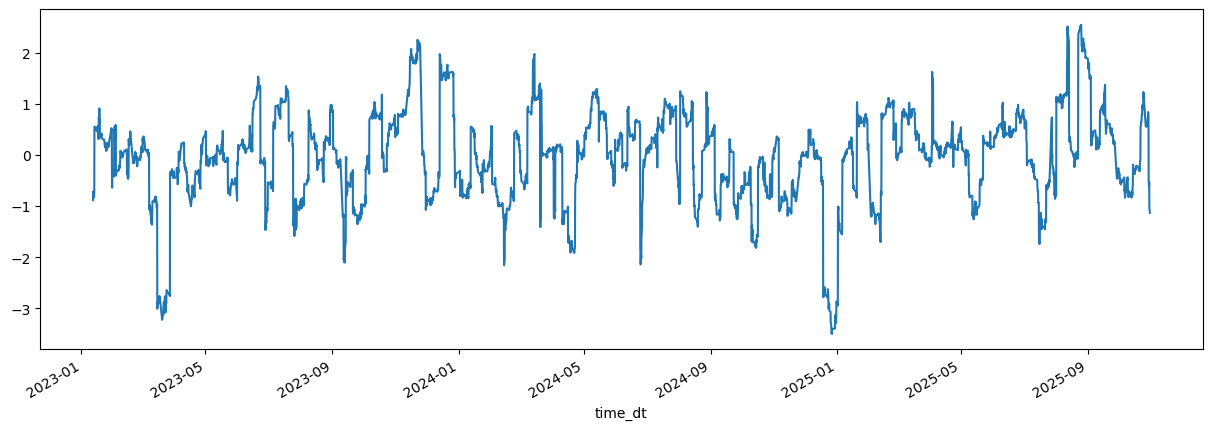

In [33]:
rolling_skew.plot(figsize=(15, 5))

array([[<Axes: title={'center': 'EURUSD'}>,
        <Axes: title={'center': 'GBPUSD'}>,
        <Axes: title={'center': 'AUDUSD'}>],
       [<Axes: title={'center': 'USDJPY'}>,
        <Axes: title={'center': 'USDCHF'}>,
        <Axes: title={'center': 'USDCAD'}>],
       [<Axes: title={'center': 'NZDUSD'}>, <Axes: >, <Axes: >]],
      dtype=object)

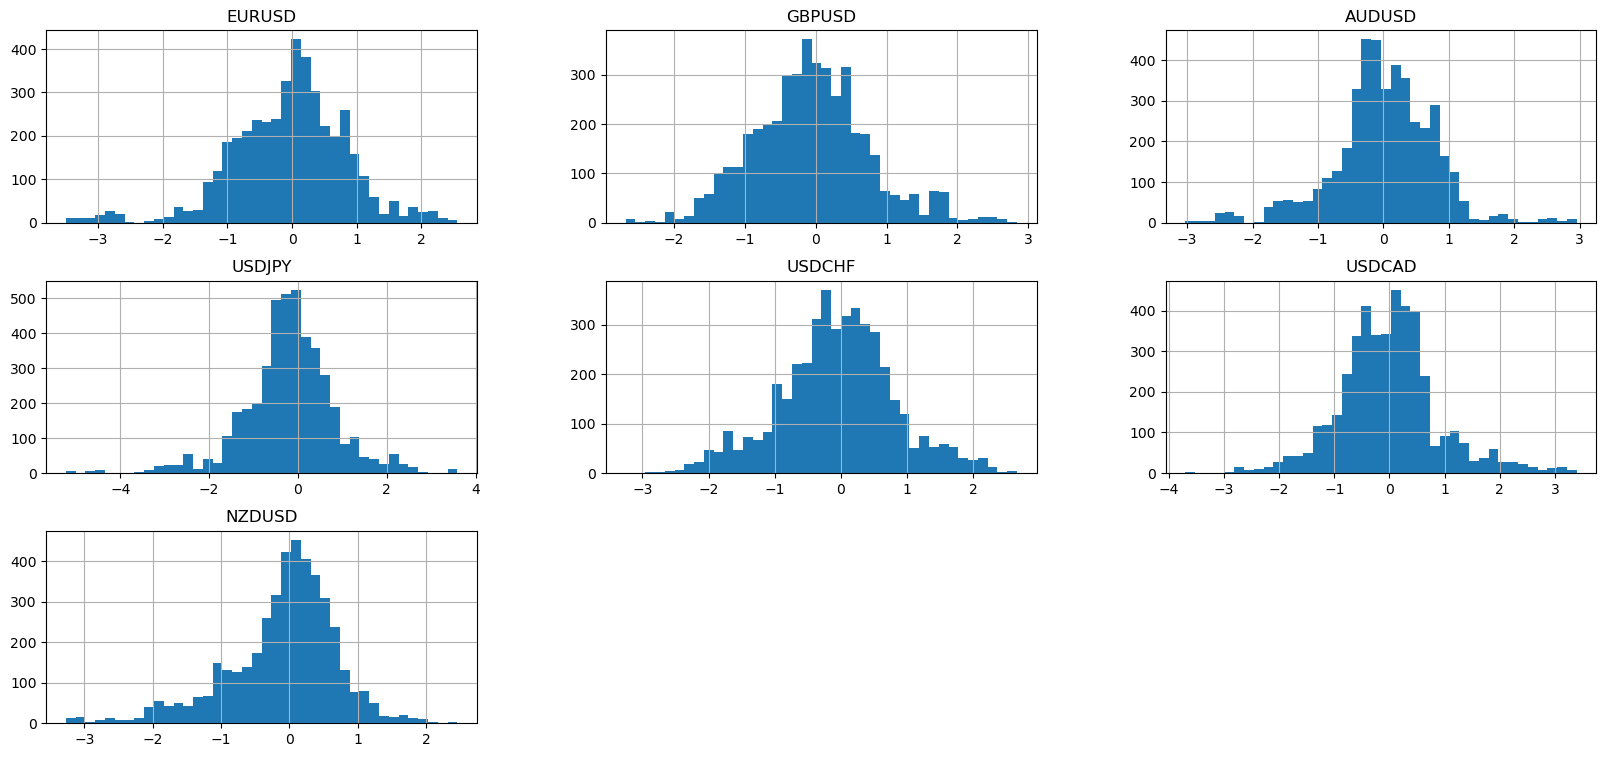

In [49]:
returns_df.rolling(rolling_win).apply(skewness_nb, raw=True, engine="numba").hist(figsize=(20, 9), bins=40)

In [36]:
from numba import njit

@njit
def _demean(X):
    """
    Demean each column of X in-place and return the column means.

    Parameters
    ----------
    X : 2D array, shape (T, N)

    Returns
    -------
    means : 1D array, shape (N,)
    """
    T, N = X.shape
    means = np.zeros(N)

    # compute means
    for j in range(N):
        s = 0.0
        for t in range(T):
            s += X[t, j]
        m = s / T
        means[j] = m

    # subtract means
    for j in range(N):
        m = means[j]
        for t in range(T):
            X[t, j] -= m

    return means


@njit
def coskewness_matrix(X):
    """
    Compute the (flattened) co-skewness matrix of asset returns.

    Parameters
    ----------
    X : 2D array, shape (T, N)
        Rows are time observations, columns are asset returns.

    Returns
    -------
    C : 2D array, shape (N*N, N)
        Co-skewness matrix such that
        C[i*N + j, k] = (1/T) * sum_t x_ti x_tj x_tk
        for centered returns x_t.
    """
    T, N = X.shape

    # Work on a copy so we don't modify the input
    Xc = X.copy()

    # Center each column (in-place)
    _ = _demean(Xc)

    # Allocate output: flattened (i,j) in rows, k in columns
    C = np.zeros((N * N, N))

    # Triple product accumulation
    for t in range(T):
        # We reuse intermediate products to avoid recomputing
        for i in range(N):
            xi = Xc[t, i]
            for j in range(N):
                xj = Xc[t, j]
                ij_idx = i * N + j
                xixj = xi * xj
                for k in range(N):
                    C[ij_idx, k] += xixj * Xc[t, k]

    # Divide by T to get sample third central moments
    invT = 1.0 / T
    for r in range(N * N):
        for k in range(N):
            C[r, k] *= invT

    return C


def coskewness(X):
    """
    Public wrapper with basic checks. X is expected as a NumPy array.

    Parameters
    ----------
    X : array-like, shape (T, N)

    Returns
    -------
    C : ndarray, shape (N*N, N)
        Co-skewness matrix of centered returns.
    """
    X = np.asarray(X, dtype=np.float64)
    if X.ndim != 2:
        raise ValueError("X must be 2D with shape (T, N).")
    return coskewness_matrix(X)


In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def estimate_ou_half_life_asymmetric(series, dt=1.0, verbose=True):
    """
    Asymmetric OU: ΔX_t = α + β_pos * X_{t-1} * 1(X_{t-1}>0)
                         + β_neg * X_{t-1} * 1(X_{t-1}<0) + e_t

    Parameters
    ----------
    series : array-like or pandas.Series
        Time series X_t (equally spaced).
    dt : float
        Time step between observations (1 for daily, 1/252 for daily in years).
    verbose : bool
        If True, prints OLS summary.

    Returns
    -------
    dict with:
        beta_pos, beta_neg, pval_pos, pval_neg,
        kappa_pos, kappa_neg, hl_pos, hl_neg,
        ols_result (full statsmodels result).
    """
    x = pd.Series(series).dropna()

    x_lag = x.shift(1)
    dx = x - x_lag

    df = pd.concat([dx, x_lag], axis=1)
    df.columns = ["dx", "x_lag"]
    df = df.dropna()

    # Piecewise regressors
    x_lag_vals = df["x_lag"].values
    dx_vals = df["dx"].values

    x_pos = np.where(x_lag_vals > 0.0, x_lag_vals, 0.0)
    x_neg = np.where(x_lag_vals < 0.0, x_lag_vals, 0.0)

    X = np.column_stack([x_pos, x_neg])
    X = sm.add_constant(X)  # [const, x_pos, x_neg]

    model = sm.OLS(dx_vals, X)
    res = model.fit()

    if verbose:
        print(res.summary())

    alpha, beta_pos, beta_neg = res.params
    pval_pos = res.pvalues[1]
    pval_neg = res.pvalues[2]

    # Convert to OU speeds (kappa) and half-lives on each side
    # In the OU interpretation, kappa_side = -beta_side / dt
    def kappa_and_hl(beta):
        kappa = -beta / dt
        if kappa > 0:
            hl = np.log(2.0) / kappa
        else:
            hl = np.nan  # non-mean-reverting or unstable
        return kappa, hl

    kappa_pos, hl_pos = kappa_and_hl(beta_pos)
    kappa_neg, hl_neg = kappa_and_hl(beta_neg)

    return {
        "alpha": alpha,
        "beta_pos": beta_pos,
        "beta_neg": beta_neg,
        "pval_pos": pval_pos,
        "pval_neg": pval_neg,
        "kappa_pos": kappa_pos,
        "kappa_neg": kappa_neg,
        "half_life_pos": hl_pos,
        "half_life_neg": hl_neg,
        "ols_result": res,
    }

# Example:
# info = estimate_ou_half_life_asymmetric(spread_series, dt=1.0)
# print("HL (X>0):", info["half_life_pos"], " p-val:", info["pval_pos"])
# print("HL (X<0):", info["half_life_neg"], " p-val:", info["pval_neg"])


In [51]:
rolling_skews = returns_df.rolling(rolling_win).apply(skewness_nb, raw=True, engine="numba")


In [57]:
info = estimate_ou_half_life_asymmetric(rolling_skews["EURUSD"], dt=1.0)
print("HL (X>0):", info["half_life_pos"], " p-val:", info["pval_pos"])
print("HL (X<0):", info["half_life_neg"], " p-val:", info["pval_neg"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     28.26
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           6.39e-13
Time:                        20:46:08   Log-Likelihood:                 792.93
No. Observations:                4360   AIC:                            -1580.
Df Residuals:                    4357   BIC:                            -1561.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.005      0.196      0.8

In [52]:
rolling_skews.columns

Index(['EURUSD', 'GBPUSD', 'AUDUSD', 'USDJPY', 'USDCHF', 'USDCAD', 'NZDUSD'], dtype='object')

In [109]:
rs_test = rolling_skews["EURUSD"].dropna()
rs_test_diff = rs_test.diff()
roll_returns = returns_df.rolling(60).mean().shift(-60)

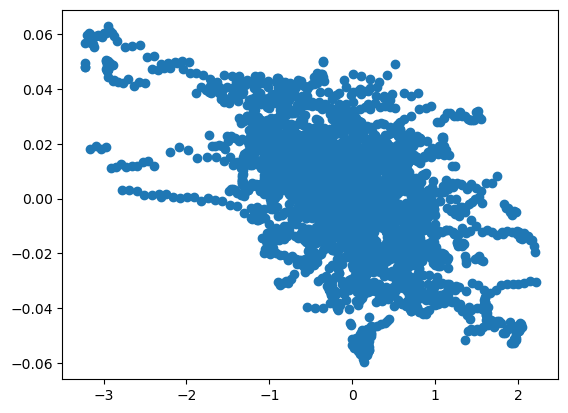

In [94]:
plt.scatter(rs_test.rolling(30).mean().values, rs_test_diff.rolling(60).mean().shift(-60).values)

In [110]:
X = pd.concat([rs_test_diff.rolling(60).mean().shift(-60), rs_test.rolling(30).mean()], axis=1).dropna()
X = pd.concat([roll_returns, rs_test.rolling(30).mean()], axis=1).dropna()

In [111]:
model = sm.OLS(X.iloc[:, 0], sm.add_constant(X.iloc[:, 1]))
res = model.fit()

In [112]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 EURUSD   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     8265.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:24:12   Log-Likelihood:                 32088.
No. Observations:                4272   AIC:                        -6.417e+04
Df Residuals:                    4270   BIC:                        -6.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.478e-06   2.03e-06      0.728      0.467    -2.5e-06    5.46e-06
GBPUSD         0.8125      0.009     90.913      0.000       0.795       0.830
==============================================================================
Omnibus:                      673.584   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1500.485
Skew:                           0.917   Prob(JB):                         0.00
Kurtosis:                       5.250   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""